# **1. 데이터 차원**
- 불균형 데이터에 대한 처리 부분 추가  
  -> **가중 무작위 샘플링(Weighted Random Sampling)** 활용
- Albumentation 적용

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - lr scheduling
    - 초기 lr: 1e-5
    - min_lr: 1e-12
- 활성화 함수/손실함수
    - 활성화 함수: log softmax
    - 손실 함수: CrossEntropyLoss --- 가중치 적용
- 배치/ Epoch
    - 충분한 학습이 이루어질 수 있도록 Epoch 수 증가
    - batch size: 128
    - Epoch: 200

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 

1.12.1+cu116


### **Random Sampling**

In [3]:
### 가중치 함수

def make_weights(df,classes):
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        weight = 1 / count    
        weights = [weight] * count    # 라벨이 뽑힐 가중치를 count의 역수로 동일하게 전체 라벨에 할당 
        weight_list += weights
 
    return weight_list

In [4]:
### 데이터 가져오기
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

In [5]:
### 가중치 생성
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
weights = make_weights(train_data_df,feelings_list)
# print(weights)

### **DataLoader**

In [6]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [7]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [8]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [9]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [10]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,shuffle = True, drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False, drop_last = False)
    
    return dataloaders

In [11]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [12]:
from torchsummary import summary

In [13]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.LogSoftmax(dim = 1) # 활성화 함수(각 클래스에 속할 확률 추정, 로그 변환)
    )
    
    return model.to(device)

### **Estimation**

In [14]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    batch_size = image.shape[0] 
    prediction = model(image).to(device) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [15]:
### Epoch을 1번 수행

def train_one_epoch(dataloaders, model, optimizer, loss_function, device):
    losses = {}  # loss값 저장
    accuracies = {} # 정확도 계산
    
    for tv in ["train", "val"]: 
        ### loss, accuracy 갱신
        running_loss = 0.0 
        running_correct = 0.0
        
        if tv == "train":
            model.train() # 학습
        else:
            model.eval() # 평가
            
            
        for index, batch in enumerate(dataloaders[tv]): 
            image = batch['image'].to(device) # feature data(이미지)
            label = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'):
                prediction = model(image) # label 예측
                loss = loss_func(prediction, label) # loss 값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # gradient를 0으로 초기화
                    loss.backward() # 역전파 적용
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image, label, model)
            
            ### 학습 과정 monitoring
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
                    
        ### loss, accuracy 저장            
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
        
    return losses, accuracies

In [16]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [17]:
### 가중 손실 함수

def get_class_weights(df,classes):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # gpu 할당
    cnt_lists = [] # 각 클래스의 데이터 수 저장
    weight_list = []   # 가중치를 저장하는 배열을 생성한다.
 
    for c in classes:
        count = len(df[df['emotion'] == str(c)]) #각 클래스의 데이터 수 카운트 
        cnt_lists.append(count)
    
    weights = [1-(x / sum(cnt_lists)) for x in cnt_lists]
    class_weights = torch.cuda.FloatTensor(weights).to(device) # 가중치 설정
    
    return class_weights


### 가중치 생성
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_weights = get_class_weights(train_data_df,feelings_list)
# print(class_weights)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model().to(device)
loss_func = nn.CrossEntropyLoss(weight = class_weights, reduction = 'mean').to(device) # 가중 손실 함수
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-12,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
num_epochs = 200

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    # LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

0/227 - Running loss: 1.9763282537460327
30/227 - Running loss: 1.8412963151931763
60/227 - Running loss: 1.6567145586013794
90/227 - Running loss: 1.805726170539856
120/227 - Running loss: 1.6574466228485107
150/227 - Running loss: 1.619680643081665
180/227 - Running loss: 1.5355890989303589
210/227 - Running loss: 1.4600951671600342
1/200-Train Loss:1.6609498251902375, Val Loss:1.4219130565380227
1/200-Train Acc:0.37183370044052866, Val Acc:0.4513077147866744
0/227 - Running loss: 1.4771755933761597
30/227 - Running loss: 1.3338075876235962
60/227 - Running loss: 1.4795080423355103
90/227 - Running loss: 1.2908598184585571
120/227 - Running loss: 1.3378876447677612
150/227 - Running loss: 1.4199055433273315
180/227 - Running loss: 1.4057155847549438
210/227 - Running loss: 1.3172754049301147
2/200-Train Loss:1.4018374177327766, Val Loss:1.2940850607280074
2/200-Train Acc:0.47725082599118945, Val Acc:0.4901510447106955
0/227 - Running loss: 1.3040430545806885
30/227 - Running loss: 1.

90/227 - Running loss: 0.7791716456413269
120/227 - Running loss: 0.7449706792831421
150/227 - Running loss: 0.8122457265853882
180/227 - Running loss: 0.8879661560058594
210/227 - Running loss: 0.9653847813606262
EarlyStopping counter: 4 out of 10
18/200-Train Loss:0.8044493324431029, Val Loss:1.0173362524345004
18/200-Train Acc:0.7165129405286343, Val Acc:0.6295660432495617
0/227 - Running loss: 0.8610825538635254
30/227 - Running loss: 0.6857340335845947
60/227 - Running loss: 0.7830090522766113
90/227 - Running loss: 0.8677406907081604
120/227 - Running loss: 0.6990712285041809
150/227 - Running loss: 0.8292423486709595
180/227 - Running loss: 0.8052045106887817
210/227 - Running loss: 0.7977228760719299
EarlyStopping counter: 5 out of 10
19/200-Train Loss:0.7729711480077668, Val Loss:1.0247603243794934
19/200-Train Acc:0.7285242290748899, Val Acc:0.6247169053185272
0/227 - Running loss: 0.7555294632911682
30/227 - Running loss: 0.8247429728507996
60/227 - Running loss: 0.732438623

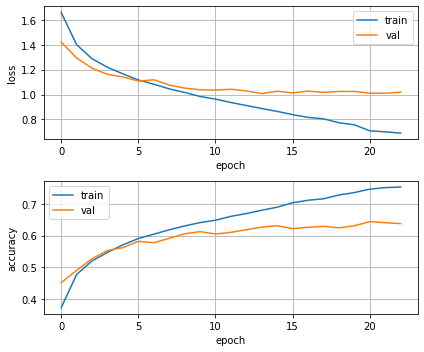

In [20]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()